In [9]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from itertools import product
from collections import defaultdict

In [2]:
# 获取项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

#### Fig1B

In [16]:
import src.animation as animation
importlib.reload(animation)
from src.animation import Processor

# 初始化语音处理器
animation_compare = Processor()

In [19]:
# 导入被试数据
iSub = 7
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)

In [20]:
# 导入模型数据
result_path = Path(project_root) / 'results' / 'Bayesian_new'
base_results = joblib.load(result_path / 'M_Base_fitting_results.joblib')

sub_result = base_results[iSub]
step_results = sub_result['step_results']

import src.Bayesian.utils.partition as partition
importlib.reload(partition)
from src.Bayesian.utils.partition import Partition

ncats=2
partition = Partition()
all_centers = partition.get_centers(4, ncats)

model_fitting = [[step['best_k'], all_centers[step['best_k']][1]] for step in step_results]

In [21]:
# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' / f'Sub{iSub}'
processed_dir = Path(project_root) / 'data' / 'processed' / 'Task2'
output_csv = os.path.join(processed_dir, f'Task2_{iSub}_processed.csv')

animation_compare.process_and_plot(ncats, subject_data, model_fitting, output_csv, plots_dir, plot_side='left')

Choice 1 在第 0 行之前没有数据，跳过生成图像。
Choice 3 在第 0 行之前没有数据，跳过生成图像。
Choice 4 在第 0 行之前没有数据，跳过生成图像。
Choice 3 在第 1 行之前没有数据，跳过生成图像。
Choice 4 在第 1 行之前没有数据，跳过生成图像。
Choice 3 在第 2 行之前没有数据，跳过生成图像。
Choice 4 在第 2 行之前没有数据，跳过生成图像。
Choice 3 在第 3 行之前没有数据，跳过生成图像。
Choice 4 在第 3 行之前没有数据，跳过生成图像。
Choice 3 在第 4 行之前没有数据，跳过生成图像。
Choice 4 在第 4 行之前没有数据，跳过生成图像。
Choice 3 在第 5 行之前没有数据，跳过生成图像。
Choice 4 在第 5 行之前没有数据，跳过生成图像。
Choice 3 在第 6 行之前没有数据，跳过生成图像。
Choice 4 在第 6 行之前没有数据，跳过生成图像。
Choice 3 在第 7 行之前没有数据，跳过生成图像。
Choice 4 在第 7 行之前没有数据，跳过生成图像。
Choice 3 在第 8 行之前没有数据，跳过生成图像。
Choice 4 在第 8 行之前没有数据，跳过生成图像。
Choice 3 在第 9 行之前没有数据，跳过生成图像。
Choice 4 在第 9 行之前没有数据，跳过生成图像。
Choice 3 在第 10 行之前没有数据，跳过生成图像。
Choice 4 在第 10 行之前没有数据，跳过生成图像。
Choice 3 在第 11 行之前没有数据，跳过生成图像。
Choice 4 在第 11 行之前没有数据，跳过生成图像。
Choice 3 在第 12 行之前没有数据，跳过生成图像。
Choice 4 在第 12 行之前没有数据，跳过生成图像。
Choice 3 在第 13 行之前没有数据，跳过生成图像。
Choice 4 在第 13 行之前没有数据，跳过生成图像。
Choice 3 在第 14 行之前没有数据，跳过生成图像。
Choice 4 在第 14 行之前没有数据，跳过生成图像。
Choice 3 在第 15 行之前没有数据，跳过生成图像。
Choice 4 在第 15 行之前没有数据，跳过生成图像

In [22]:
# 得到GIF动图
plots_parent_dir = Path(project_root) / 'results' / 'Nips_figures' / f'Sub{iSub}'

# 定义子文件夹及对应的文件名模式
choices = {
    'choice1': r'^\d+_(\d+)_(\d+)_c1\.png$',
    'choice2': r'^\d+_(\d+)_(\d+)_c2\.png$',
    'choice3': r'^\d+_(\d+)_(\d+)_c3\.png$',
    'choice4': r'^\d+_(\d+)_(\d+)_c4\.png$',
}

# 遍历每个子文件夹并生成GIF
for choice, pattern in choices.items():
    sub_dir = plots_parent_dir / choice
    if not sub_dir.exists() or not sub_dir.is_dir():
        print(f"子文件夹 '{sub_dir}' 不存在或不是一个文件夹，已跳过。")
        continue

    # 定义输出GIF的路径，保存到Plots父文件夹下
    output_gif = plots_parent_dir / f'{choice}_animation.gif'

    # 创建GIF
    animation_compare.create_sorted_gif(sub_dir, output_gif, pattern, duration=0.5)

GIF已成功创建并保存为 '/home/yangjiong/CategoryLearning/results/Nips_figures/Sub7/choice1_animation.gif'。
GIF已成功创建并保存为 '/home/yangjiong/CategoryLearning/results/Nips_figures/Sub7/choice2_animation.gif'。
在文件夹 '/home/yangjiong/CategoryLearning/results/Nips_figures/Sub7/choice3' 中未找到符合格式的PNG图像。
在文件夹 '/home/yangjiong/CategoryLearning/results/Nips_figures/Sub7/choice4' 中未找到符合格式的PNG图像。


#### Fig1C

In [23]:
# 生成每个被试内部的试次编号
learning_data['trial_in_sub'] = learning_data.groupby('iSub').cumcount() + 1

# 计算滑动窗口正确率
learning_data['rolling_accuracy'] = learning_data.groupby('iSub')[
    'feedback'].transform(lambda x: x.rolling(16, min_periods=16).mean())

# 四列相加，生成 feature_use
feature_cols = ['feature1_use', 'feature2_use', 'feature3_use', 'feature4_use']
learning_data['feature_use'] = learning_data[feature_cols].sum(axis=1)

# 对 feature_use 求滑动窗口平均（窗口长度 16）
learning_data['rolling_feature_use'] = (
    learning_data
    .groupby('iSub')['feature_use']
    .transform(lambda x: x.rolling(16, min_periods=16).mean())
)

In [59]:
iSub = 5
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)

In [68]:
palette_nature = {'Accuracy': '#DDAA33',      'Feature Use': '#004488'}
palette_science = {'Accuracy': '#117733',     'Feature Use': '#CC6677'}
palette_neurosci = {'Accuracy': '#1B9E77',    'Feature Use': '#D95F02'}
palette_comm    = {'Accuracy': '#E41A1C',     'Feature Use': '#377EB8'}

# 选择配色，这里以Nature配色为例
colors = palette_comm
color_acc   = colors['Accuracy']
color_feat  = colors['Feature Use']

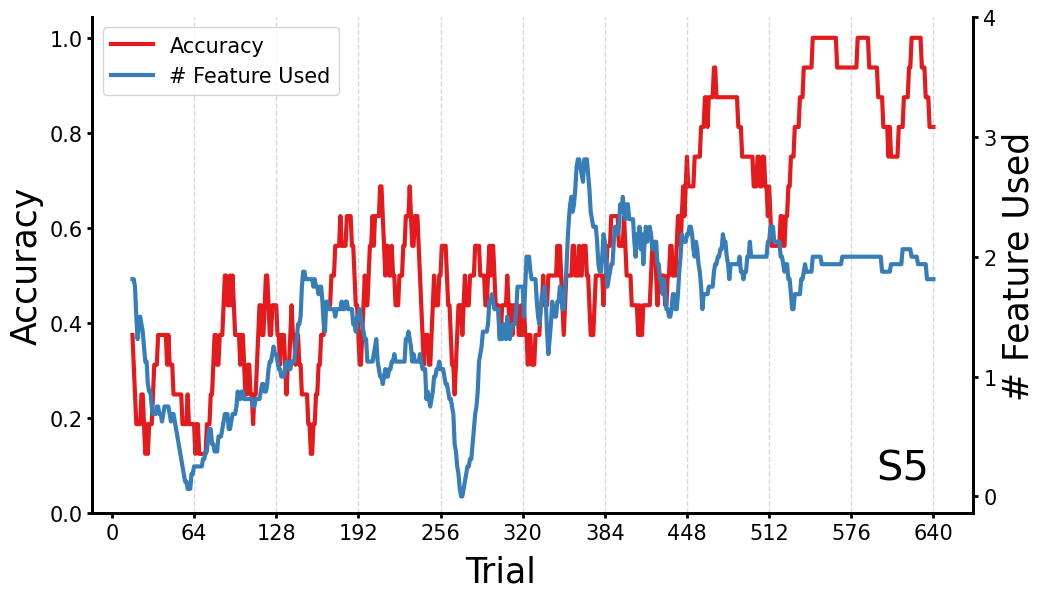

In [69]:
fig, ax1 = plt.subplots(figsize=(11, 6))
ax2 = ax1.twinx()

# 画主坐标轴（Accuracy）
line1, = ax1.plot(
    subject_data['trial_in_sub'],
    subject_data['rolling_accuracy'],
    label='Accuracy',
    color=color_acc,
    linewidth=3,
    alpha=1
)

# 画副坐标轴（Feature Use）
line2, = ax2.plot(
    subject_data['trial_in_sub'],
    subject_data['rolling_feature_use'],
    label='# Feature Used',
    color=color_feat,
    linewidth=3,
    alpha=1
)

# 绘制每 64 trial 的分割线（在主轴上即可，副轴会跟随）
max_trial = subject_data['trial_in_sub'].max()
for x in range(64, max_trial + 1, 64):
    ax1.axvline(x=x, color='grey', alpha=0.3, linestyle='dashed', linewidth=1)

# 设置 X 轴刻度
ax1.set_xticks(range(0, max_trial + 1, 64))
ax1.set_xticklabels(range(0, max_trial + 1, 64), fontsize=15)

# 主轴 Y 轴（Accuracy）刻度与标签
ax1.set_yticks([i / 5 for i in range(6)])
ax1.set_yticklabels([f"{i / 5:.1f}" for i in range(6)], fontsize=15)
ax1.set_ylabel('Accuracy', fontsize=25)

# 副轴 Y 轴（Feature Use）刻度与标签
ax2.set_yticks(range(0, 5))  # 0,1,2,3,4
ax2.set_yticklabels([str(i) for i in range(5)], fontsize=15)
ax2.set_ylabel('# Feature Used', fontsize=25)

# 去掉网格
ax1.grid(False)

# 隐藏不需要的脊线
for spine in ['top']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# 加粗剩余的脊线和刻度
for spine in ['left', 'bottom', 'right']:
    ax1.spines[spine].set_linewidth(2.0)
    ax2.spines[spine].set_linewidth(2.0)
ax1.tick_params(width=2.0)
ax2.tick_params(width=2.0)

# 在右下角添加被试编号
ax1.text(
    0.95, 0.05, f"S{iSub}",
    transform=ax1.transAxes,
    fontsize=30, ha='right', va='bottom', color='black'
)

# 设置坐标轴标签字体大小
fig.text(0.5, 0.02, 'Trial', ha='center', fontsize=25)

# 统一透明背景
ax1.set_facecolor('none')
ax2.set_facecolor('none')

# 合并图例（可选）
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=15)

plt.tight_layout(rect=[0.04, 0.06, 1, 1])
plt.show()
